# How to make a portfolio and ~~get rich~~ backtest it

You've done prediction. You've done optimizing. It's time to combine these two worlds.

Seeing the impeccable timing of this notebook, most of the helpers are provided pre-written for you. You may use these or modify them to your liking, in case you really want to get your hands dirty with amateur portfolio management.

## Backtesting: The Rightside Up
Backtesting helpers are in `backtesting_utils.py`. You may need to use helpers from week4 in `helpers.py`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from backtesting_utils import (
    load_return_data,
    plot_wealth,
    plot_returns,
    plot_weights_over_time,
    plot_weights_stacked_area,
    plot_turnover,
    print_performance_summary
)

from helpers import (
    save_predictions,
    load_predictions,
    plot_mu_and_cov,
    visualize_weights_stacked,
    visualize_return_risk,
    compute_sharpe_ratios,
    plot_sharpe_ratios,
    print_sharpe_table,
    visualize_single_portfolio,
)

sns.set_theme(style="darkgrid")


### Basic backtesting enginre
A generic backtesting engine that takes in a _strategy function_ whose signature is
$$
\texttt{strategy\_fn} : (t, \text{returns}, \mathbf{w}_{t-1}, [L, ...]) \mapsto \mathbf{w}_{t}
$$
where `returns` has shape `(T, n_assets)`. It must handle
- making predictions ($\hat\mu_t$, $\hat\Sigma_t$) based on returns data in range $[t-L, \dots, t-1]$
- calling the optimizer
- returning target portfolio weights $w_t$

It handles periodic rebalancing.

It accounts for transaction cost as an _external cost_ (that is, the strategy function does not take it into account; this is a naive optimizing scheme).

In [3]:
def run_backtest(
    returns,                     # array (T, n_assets)
    dates,
    initial_wealth,
    strategy_fn,                  # (t, returns, prev_weights) -> weights
    lookback=60,                  # estimation window
    rebalance_period=21,          # 5 = weekly, 21 = monthly
    transaction_cost_factor=0.0,
):
    returns = np.asarray(returns)
    T, n = returns.shape

    wealth = np.zeros(T)
    cash = np.zeros(T)
    port_returns = np.zeros(T)
    turnover = np.zeros(T)
    weights_hist = np.zeros((T, n))

    wealth[0] = initial_wealth
    cash[0] = initial_wealth
    weights = np.zeros(n)

    for t in range(lookback, T - 1):

        # ------------------------------
        # Rebalance (only at chosen times)
        # ------------------------------
        if t % rebalance_period == 0:
            target_weights = strategy_fn(t, returns, weights)

            trade = np.abs(target_weights - weights).sum()
            cost = transaction_cost_factor * trade * wealth[t]

            weights = target_weights
            turnover[t] = trade
            cash[t] -= cost
        else:
            cost = 0.0

        # ------------------------------
        # Apply next-period returns
        # ------------------------------
        port_ret = weights @ returns[t + 1]
        port_returns[t + 1] = port_ret

        wealth[t + 1] = wealth[t] * (1 + port_ret) - cost
        cash[t + 1] = cash[t] * (1 + port_ret) - cost

        weights_hist[t + 1] = weights

    return {
        "wealth": wealth,
        "cash": cash,
        "returns": port_returns,
        "weights": weights_hist,
        "turnover": turnover,
        "dates": dates,
    }


## Backtesting the 1/N portfolio
A (painfully) simple tested portfolio by the backtester.

#### 1. Load your data

In [4]:
tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "TLT"]

returns_df = load_return_data(
    tickers,
    start="2017-01-01",
    end="2017-12-31",
)

display(returns_df.head()) # shape: (T, n_assets)

returns = returns_df.values
dates = returns_df.index.astype(str).tolist()
tickers = list(returns_df.columns)

n_assets = len(tickers)


Ticker,AAPL,MSFT,AMZN,GOOG,TLT
Date,,,,,
2017-01-04,-0.001120,-0.004474,0.004657,0.000967,0.003845
2017-01-05,0.005085,0.000000,0.030732,0.009048,0.015654
2017-01-06,0.011148,0.008668,0.019912,0.015277,-0.009182
2017-01-09,0.009160,-0.003182,0.001168,0.000620,0.008026
2017-01-10,0.001008,-0.000319,-0.001280,-0.002306,-0.000656


#### 2. Build a predictor
Unused here, only for completeness.

#### 3. Set up a simple baseline portfolio (1/N, GMVP etc)
We only work with 1/N here so no need for baseline, in reality you would need a baseline to compare against.

In [5]:
# sample predictor, this is where week 2 and ~3~ will come in handy
# ! unused here
def predict_mu_sigma(returns_window):
    mu_hat = returns_window.mean(axis=0)
    Sigma_hat = np.cov(returns_window, rowvar=False)
    return mu_hat, Sigma_hat


#### 4. Write the markowitz optimizer routine using cvxpy
Not using any optimizer here. This is where you would copy your favourite optimizer routine!

#### 5. Write the strategy function combining the above
The below is a simplistic example.

A markowitz based implementation can look like (this will help u in task5):

```python
def markowitz_strategy_fn(t, returns, prev_weights, L=60, lam=1.0):
    window = returns[t-L:t]
    mu_hat = window.mean(axis=0)
    Sigma_hat = np.cov(window, rowvar=False)
    w_opt, _, _ = markowitz_portfolio(mu_hat, Sigma_hat, lam=lam)
    return w_opt
```

In [6]:
# SIMPLE STRATEGY
# equal weights with some noise based on time
def equal_weight_strategy(t, returns, current_weights, lookback=60):
    np.random.seed(t)
    # returns, lookback unused
    w_opt = current_weights + np.abs(np.random.randn(*current_weights.shape)) * 0.01
    w_opt = w_opt / (w_opt.sum())
    return w_opt

#### 6. Write the backtester

In [7]:
results = run_backtest(
    returns=returns,
    dates=dates,
    initial_wealth=1.0,
    strategy_fn=lambda t, r, w: equal_weight_strategy(t, r, w),
    lookback=10,  # dummy
    rebalance_period=21,
    transaction_cost_factor=0.001,
)

#### 7. Plot diagnostics

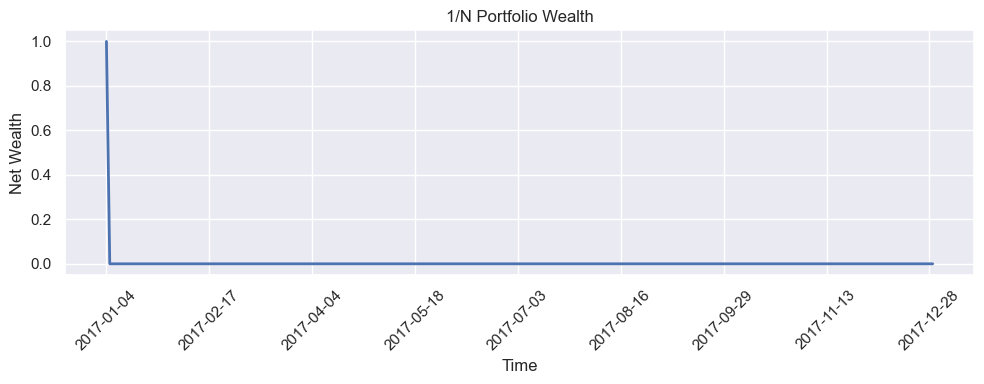

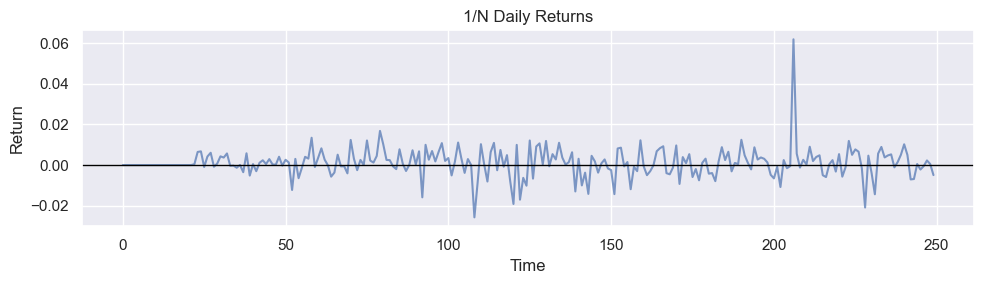

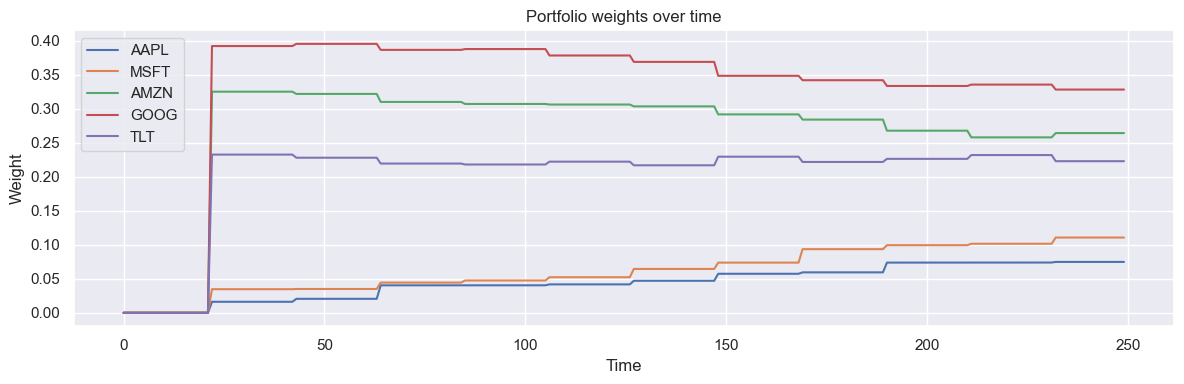

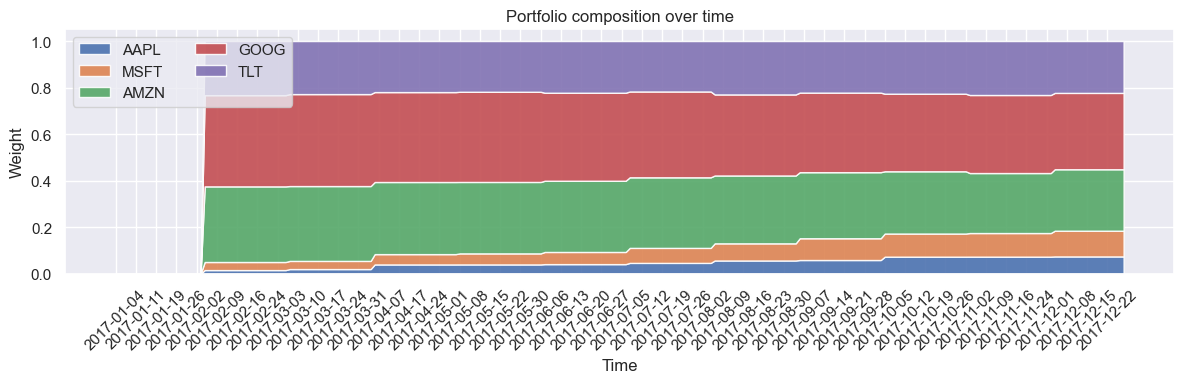

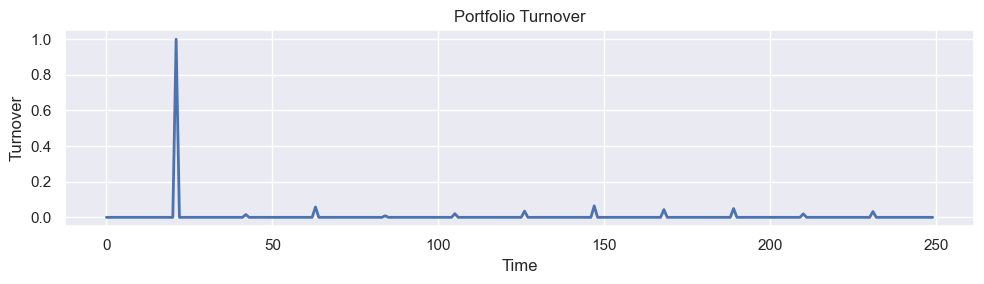

In [8]:
# diagnostics
plot_wealth(results["wealth"], results["dates"], title="1/N Portfolio Wealth")
plot_returns(results["returns"], title="1/N Daily Returns")
plot_weights_over_time(results["weights"], tickers)
plot_weights_stacked_area(results["weights"], tickers, dates)
plot_turnover(results["turnover"])

> NOTE: graph is zero'ed in the beginning because in [0, L-1] no predictions can be made

In [9]:
print_performance_summary(results["wealth"], results["returns"])


Performance summary
-------------------
Total return:     -100.00%
Avg daily return: 0.0011
Daily volatility: 0.0073


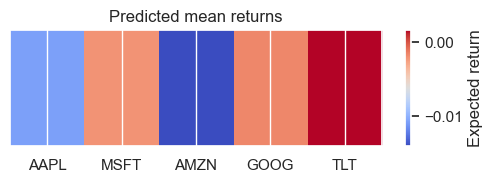

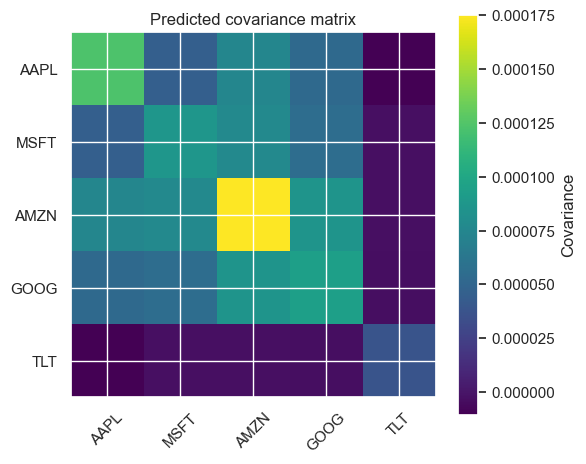

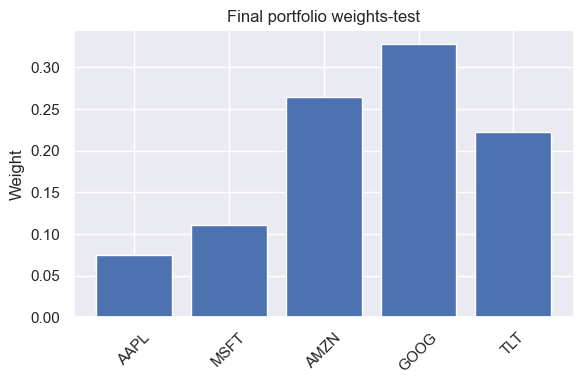

Final portfolio statistics
---------------------------
Expected return : -0.0049
Volatility      : 0.0074
Sharpe ratio    : -0.6700


In [10]:
# visualize portfolio
visualize_single_portfolio(
    mu=returns[-1],
    Sigma=returns_df.cov().values,
    w=results["weights"][-1],
    tickers=tickers,
    title_suffix="-test"
)

## Bonus - Transaction Cost where?

Our current implementation suffers from a critical flaw:
> The optimizer is not aware of the transaction cost.

In reality, the optimized objective should be "transaction cost"-aware and/or conditions on the transaction cost can be added in the constraints section. This is exactly the focus of a paper by Boyd et al. mentioned before. You may refer to that in order to implement those constraints in your portfolio optimizer.

It can be found [here](https://web.stanford.edu/~boyd/papers/pdf/markowitz.pdf), see pages 13-18.

You may design an optimizer with the signature: